# Fix seeds

In [1]:
import os
import torch
import random
import numpy as np

seed = 1996

random.seed(seed)

np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.determenistic = True
torch.use_deterministic_algorithms(True)

os.environ['PYTHONHASHSEED'] = str(seed)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(device)

cuda:0


# Load train data

In [2]:
import pandas as pd
from tqdm import tqdm
from pathlib import Path

xs = []
ys = []
ys_ = []

traindir = Path('./data/train/')
print(traindir.absolute())


for datapath in tqdm([*sorted(traindir.glob('*_data.csv'))]):
    eventpath = datapath.parent / ( datapath.stem[:-5] + '_events.csv' )
    
    
    x = pd.read_csv(datapath)
    y = pd.read_csv(eventpath)

    x = x.iloc[:,1:].values
    y_ = y.iloc[:,1:].values

    xs.append(x.astype(np.float32))
    ys.append(y_.astype(np.uint8))

xs_train = xs[:-2]
ys_train = ys[:-2]

xs_valid = xs[-2:]
ys_valid = ys[-2:]

print(len(xs_train))


e:\GitHub\HQA_EEG\data\train


100%|██████████| 96/96 [00:33<00:00,  2.85it/s]

94


In [3]:
import ecgmentations as E

from torch.utils.data import DataLoader, Dataset

class EEGDataset(Dataset):
    def __init__(self, x, y, augs=dict, train=False):
        self.x = x
        self.y = y
        self.augs = augs
        
        self.train = train

    def __getitem__(self, idx):
        eeg = self.x[idx]
        mask = self.y[idx]

        if self.train:
            length = mask.shape[0]

            size = 5000
            smask = (np.sum(mask[:-size], axis=1) > 0).astype(np.uint8)
            smask = smask * 5 + 1
            p = smask / smask.sum()

            jdx = np.random.choice(length-size, p=p)

            eeg = eeg[jdx:jdx+size]
            mask = mask[jdx:jdx+size]

        auged = self.augs(ecg=eeg, mask=mask)
        eeg, mask = auged['ecg'], auged['mask']

        return eeg.T, mask.T

    def __len__(self):
        return len(self.x)

augs = E.Sequential([
    E.TimeCrop(length=5000, p=1.0),
])

dataset = EEGDataset(xs_train, ys_train, augs, True) 
train_dataloader = DataLoader(dataset, batch_size=25, shuffle=True)

dataset = EEGDataset(xs_train, ys_train) 
train_dataloader_ = DataLoader(dataset, batch_size=1,shuffle=False)

dataset = EEGDataset(xs_valid, ys_valid)
valid_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Train model

In [4]:
print(dataset.x[0].shape)

(128210, 32)


In [8]:
import copy
import torch.nn.functional as F

from sklearn import metrics
from nnspt.segmentation.unet import Unet

model = Unet(in_channels=32, out_channels=6, encoder='timm-efficientnet-b1')
model.to(device)

nepochs = 10000

opt = torch.optim.AdamW(model.parameters(), lr=0.00175)
shed = torch.optim.lr_scheduler.CosineAnnealingLR(opt, nepochs*len(train_dataloader))

loss_his, train_loss = [], []

best_score = 0.
best_state_dict = copy.deepcopy(model.state_dict())

for epoch in range(nepochs):
    model.train()
    
    for i, (eeg_batch, mask_batch) in enumerate(train_dataloader):
        eeg_batch, mask_batch = eeg_batch.to(device), mask_batch.to(device)

        logits = model(eeg_batch)
        loss = F.binary_cross_entropy_with_logits(logits, mask_batch.float())
        loss.backward()

        opt.step()
        shed.step()
        opt.zero_grad()

        train_loss.append(loss.item())
        
    if (epoch + 1) % 25 == 0:
        loss_his.append(np.mean(train_loss))
        train_loss.clear()

        print('[Epoch {}/{}] [Loss: {}]'.format(epoch+1, nepochs, loss_his[-1]))
        
        model.eval()

        y_pred = []

        size = 10000
        
        for eeg_batch, _ in tqdm(valid_dataloader):
            for idx in range((eeg_batch.shape[-1] + size - 1) // size):
                with torch.no_grad():
                    eeg_batch_ = eeg_batch[:, :, idx*size: (idx+1)*size].to(device)

                    logits = model(eeg_batch_)
                    probs = torch.sigmoid(logits).cpu().numpy()[0]

                    y_pred.append(probs)

        y_pred = np.concatenate(y_pred, axis=1).T
        y_true = np.concatenate(ys_valid, axis=0)

        score = metrics.roc_auc_score(y_true, y_pred)

        print('[Epoch {}/{}] [Score: {}]'.format(epoch+1, nepochs, score))

        if score > best_score:
            best_score = score
            best_state_dict = copy.deepcopy(model.state_dict())
    
model.load_state_dict(best_state_dict)

[Epoch 25/10000] [Loss: 0.2096778278797865]


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


[Epoch 25/10000] [Score: 0.5457208031859336]
[Epoch 50/10000] [Loss: 0.12650021098554134]


100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


[Epoch 50/10000] [Score: 0.598761057185762]
[Epoch 75/10000] [Loss: 0.12500339545309544]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 75/10000] [Score: 0.6243104414962077]
[Epoch 100/10000] [Loss: 0.12351937912404537]


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


[Epoch 100/10000] [Score: 0.6405668597654999]
[Epoch 125/10000] [Loss: 0.12131107524037361]


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


[Epoch 125/10000] [Score: 0.6664363649200555]
[Epoch 150/10000] [Loss: 0.11840400241315364]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 150/10000] [Score: 0.6788998735614227]
[Epoch 175/10000] [Loss: 0.11858946964144707]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 175/10000] [Score: 0.6969049590116233]
[Epoch 200/10000] [Loss: 0.11638994671404362]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 200/10000] [Score: 0.7759482443372727]
[Epoch 225/10000] [Loss: 0.11163699693977833]


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


[Epoch 225/10000] [Score: 0.8041508506630298]
[Epoch 250/10000] [Loss: 0.10748584151268005]


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


[Epoch 250/10000] [Score: 0.863071282040797]
[Epoch 275/10000] [Loss: 0.10232516124844551]


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


[Epoch 275/10000] [Score: 0.8954138794831343]
[Epoch 300/10000] [Loss: 0.09768974035978317]


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


[Epoch 300/10000] [Score: 0.9043678400924314]
[Epoch 325/10000] [Loss: 0.09333953015506267]


100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


[Epoch 325/10000] [Score: 0.9046267155118967]
[Epoch 350/10000] [Loss: 0.08972029648721218]


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


[Epoch 350/10000] [Score: 0.918714559733755]
[Epoch 375/10000] [Loss: 0.08887949340045452]


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


[Epoch 375/10000] [Score: 0.9234575523202743]
[Epoch 400/10000] [Loss: 0.08617338128387927]


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


[Epoch 400/10000] [Score: 0.9344416685089486]
[Epoch 425/10000] [Loss: 0.08382158920168876]


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


[Epoch 425/10000] [Score: 0.9186077896458537]
[Epoch 450/10000] [Loss: 0.08119124554097652]


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


[Epoch 450/10000] [Score: 0.9303093481537993]
[Epoch 475/10000] [Loss: 0.07966537326574326]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 475/10000] [Score: 0.932328404317361]
[Epoch 500/10000] [Loss: 0.07884346581995487]


100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


[Epoch 500/10000] [Score: 0.9398421694179498]
[Epoch 525/10000] [Loss: 0.07541300993412733]


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


[Epoch 525/10000] [Score: 0.9457872965183639]
[Epoch 550/10000] [Loss: 0.07364893898367882]


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


[Epoch 550/10000] [Score: 0.9539207552413455]
[Epoch 575/10000] [Loss: 0.07210836615413427]


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


[Epoch 575/10000] [Score: 0.9513674081012803]
[Epoch 600/10000] [Loss: 0.06977891467511654]


100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


[Epoch 600/10000] [Score: 0.9593368860622107]
[Epoch 625/10000] [Loss: 0.06754183981567621]


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


[Epoch 625/10000] [Score: 0.9515930355234019]
[Epoch 650/10000] [Loss: 0.06622077748179436]


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


[Epoch 650/10000] [Score: 0.9497623448330063]
[Epoch 675/10000] [Loss: 0.06512747615575791]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 675/10000] [Score: 0.9576017025480356]
[Epoch 700/10000] [Loss: 0.06371496506035328]


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


[Epoch 700/10000] [Score: 0.9598461469964734]
[Epoch 725/10000] [Loss: 0.06304383613169193]


100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


[Epoch 725/10000] [Score: 0.9618421488786361]
[Epoch 750/10000] [Loss: 0.061802016012370585]


100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


[Epoch 750/10000] [Score: 0.9711760493858813]
[Epoch 775/10000] [Loss: 0.060102474614977835]


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


[Epoch 775/10000] [Score: 0.9681217162722372]
[Epoch 800/10000] [Loss: 0.05819844391196966]


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


[Epoch 800/10000] [Score: 0.9610367260831872]
[Epoch 825/10000] [Loss: 0.057805323153734205]


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


[Epoch 825/10000] [Score: 0.9698145194484803]
[Epoch 850/10000] [Loss: 0.057765444926917556]


100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


[Epoch 850/10000] [Score: 0.9571170329493187]
[Epoch 875/10000] [Loss: 0.056371386945247653]


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


[Epoch 875/10000] [Score: 0.9693663462334067]
[Epoch 900/10000] [Loss: 0.055060392133891585]


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


[Epoch 900/10000] [Score: 0.9694990013474216]
[Epoch 925/10000] [Loss: 0.05462904285639524]


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


[Epoch 925/10000] [Score: 0.9658423932272499]
[Epoch 950/10000] [Loss: 0.053762968108057974]


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


[Epoch 950/10000] [Score: 0.9682105859755704]
[Epoch 975/10000] [Loss: 0.052862066887319085]


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


[Epoch 975/10000] [Score: 0.9700873055274423]
[Epoch 1000/10000] [Loss: 0.05237768236547709]


100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


[Epoch 1000/10000] [Score: 0.967950977204104]
[Epoch 1025/10000] [Loss: 0.05112602412700653]


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


[Epoch 1025/10000] [Score: 0.9681932071271712]
[Epoch 1050/10000] [Loss: 0.05143137406557798]


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


[Epoch 1050/10000] [Score: 0.9665124956232493]
[Epoch 1075/10000] [Loss: 0.050494387038052084]


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


[Epoch 1075/10000] [Score: 0.9639481553912624]
[Epoch 1100/10000] [Loss: 0.04946706749498844]


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


[Epoch 1100/10000] [Score: 0.9694771218202534]
[Epoch 1125/10000] [Loss: 0.04849223144352436]


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


[Epoch 1125/10000] [Score: 0.9722698502682704]
[Epoch 1150/10000] [Loss: 0.04664831817150116]


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


[Epoch 1150/10000] [Score: 0.9695533837061664]
[Epoch 1175/10000] [Loss: 0.04800628915429115]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 1175/10000] [Score: 0.9659860151766759]
[Epoch 1200/10000] [Loss: 0.04696183819323778]


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


[Epoch 1200/10000] [Score: 0.9624244971235908]
[Epoch 1225/10000] [Loss: 0.045934470780193803]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 1225/10000] [Score: 0.9678100624706619]
[Epoch 1250/10000] [Loss: 0.04588223744183779]


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


[Epoch 1250/10000] [Score: 0.9719605973567194]
[Epoch 1275/10000] [Loss: 0.0452931023016572]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 1275/10000] [Score: 0.971019446769926]
[Epoch 1300/10000] [Loss: 0.04352065566927195]


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


[Epoch 1300/10000] [Score: 0.9700245291052857]
[Epoch 1325/10000] [Loss: 0.04342413794249296]


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


[Epoch 1325/10000] [Score: 0.9673598878372441]
[Epoch 1350/10000] [Loss: 0.043334215395152566]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 1350/10000] [Score: 0.9745766720332445]
[Epoch 1375/10000] [Loss: 0.04216488678008318]


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


[Epoch 1375/10000] [Score: 0.9758090892892285]
[Epoch 1400/10000] [Loss: 0.041660050228238106]


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


[Epoch 1400/10000] [Score: 0.9706929829651219]
[Epoch 1425/10000] [Loss: 0.041035073045641184]


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


[Epoch 1425/10000] [Score: 0.9716269717474885]
[Epoch 1450/10000] [Loss: 0.040783898942172526]


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


[Epoch 1450/10000] [Score: 0.9763319283005173]
[Epoch 1475/10000] [Loss: 0.041597155332565305]


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


[Epoch 1475/10000] [Score: 0.9726257710828401]
[Epoch 1500/10000] [Loss: 0.0402800577506423]


100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


[Epoch 1500/10000] [Score: 0.9690330098451333]
[Epoch 1525/10000] [Loss: 0.040448651146143676]


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


[Epoch 1525/10000] [Score: 0.9755859182651925]
[Epoch 1550/10000] [Loss: 0.0395276221819222]


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


[Epoch 1550/10000] [Score: 0.9723802386963758]
[Epoch 1575/10000] [Loss: 0.03928810246288776]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 1575/10000] [Score: 0.9759234066763871]
[Epoch 1600/10000] [Loss: 0.039941393844783304]


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


[Epoch 1600/10000] [Score: 0.9738793074255249]
[Epoch 1625/10000] [Loss: 0.037749380692839625]


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


[Epoch 1625/10000] [Score: 0.9709290719928102]
[Epoch 1650/10000] [Loss: 0.03747369538992643]


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


[Epoch 1650/10000] [Score: 0.97617706170915]
[Epoch 1675/10000] [Loss: 0.03703679550439119]


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


[Epoch 1675/10000] [Score: 0.9782861650923675]
[Epoch 1700/10000] [Loss: 0.035962729044258596]


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


[Epoch 1700/10000] [Score: 0.9742175780744171]
[Epoch 1725/10000] [Loss: 0.037562859915196894]


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


[Epoch 1725/10000] [Score: 0.9728387013022589]
[Epoch 1750/10000] [Loss: 0.03613037368282676]


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


[Epoch 1750/10000] [Score: 0.9760031618429762]
[Epoch 1775/10000] [Loss: 0.036283015254884955]


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


[Epoch 1775/10000] [Score: 0.9733771466644368]
[Epoch 1800/10000] [Loss: 0.03549361556768418]


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


[Epoch 1800/10000] [Score: 0.9717125031135097]
[Epoch 1825/10000] [Loss: 0.03511160111054778]


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


[Epoch 1825/10000] [Score: 0.9751234126225384]
[Epoch 1850/10000] [Loss: 0.03611972222104669]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 1850/10000] [Score: 0.9771920860706662]
[Epoch 1875/10000] [Loss: 0.03443290509283543]


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


[Epoch 1875/10000] [Score: 0.9715801997834945]
[Epoch 1900/10000] [Loss: 0.033754271566867826]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 1900/10000] [Score: 0.9771789925909918]
[Epoch 1925/10000] [Loss: 0.03315814483910799]


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


[Epoch 1925/10000] [Score: 0.9751174925613874]
[Epoch 1950/10000] [Loss: 0.03377680841833353]


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


[Epoch 1950/10000] [Score: 0.9768354380605647]
[Epoch 1975/10000] [Loss: 0.033745303936302665]


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


[Epoch 1975/10000] [Score: 0.9730195508575238]
[Epoch 2000/10000] [Loss: 0.03258071575313806]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 2000/10000] [Score: 0.9783009780573574]
[Epoch 2025/10000] [Loss: 0.03201354440301657]


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


[Epoch 2025/10000] [Score: 0.9784849100071903]
[Epoch 2050/10000] [Loss: 0.03114925552159548]


100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


[Epoch 2050/10000] [Score: 0.9772769631537227]
[Epoch 2075/10000] [Loss: 0.032774336878210304]


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


[Epoch 2075/10000] [Score: 0.980403903040649]
[Epoch 2100/10000] [Loss: 0.031077209543436766]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 2100/10000] [Score: 0.973132445368088]
[Epoch 2125/10000] [Loss: 0.031052530501037835]


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


[Epoch 2125/10000] [Score: 0.9736402408961987]
[Epoch 2150/10000] [Loss: 0.03055063573643565]


100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


[Epoch 2150/10000] [Score: 0.9733968706618521]
[Epoch 2175/10000] [Loss: 0.031242207735776902]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 2175/10000] [Score: 0.9753196477277423]
[Epoch 2200/10000] [Loss: 0.029621758591383697]


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


[Epoch 2200/10000] [Score: 0.9729027296175464]
[Epoch 2225/10000] [Loss: 0.030042947828769685]


100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


[Epoch 2225/10000] [Score: 0.9708744201803668]
[Epoch 2250/10000] [Loss: 0.030072461552917956]


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


[Epoch 2250/10000] [Score: 0.9777637311767773]
[Epoch 2275/10000] [Loss: 0.029669422153383494]


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


[Epoch 2275/10000] [Score: 0.9791977198992431]
[Epoch 2300/10000] [Loss: 0.029671323765069247]


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


[Epoch 2300/10000] [Score: 0.9754478009649724]
[Epoch 2325/10000] [Loss: 0.028758232370018958]


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


[Epoch 2325/10000] [Score: 0.9771010604715199]
[Epoch 2350/10000] [Loss: 0.028974232096225024]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 2350/10000] [Score: 0.9779917872762319]
[Epoch 2375/10000] [Loss: 0.027808600272983312]


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


[Epoch 2375/10000] [Score: 0.9740360270476803]
[Epoch 2400/10000] [Loss: 0.027880386039614676]


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


[Epoch 2400/10000] [Score: 0.9748943174441308]
[Epoch 2425/10000] [Loss: 0.027516502793878315]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 2425/10000] [Score: 0.9751996075859632]
[Epoch 2450/10000] [Loss: 0.028308760337531567]


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


[Epoch 2450/10000] [Score: 0.9731797895842492]
[Epoch 2475/10000] [Loss: 0.026653498243540526]


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


[Epoch 2475/10000] [Score: 0.9755220291193956]
[Epoch 2500/10000] [Loss: 0.026779185477644206]


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


[Epoch 2500/10000] [Score: 0.9764808974266409]
[Epoch 2525/10000] [Loss: 0.026532425116747617]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 2525/10000] [Score: 0.9725116952955147]
[Epoch 2550/10000] [Loss: 0.02641855550929904]


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


[Epoch 2550/10000] [Score: 0.9710529302106337]
[Epoch 2575/10000] [Loss: 0.02598220931366086]


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


[Epoch 2575/10000] [Score: 0.9791221581203954]
[Epoch 2600/10000] [Loss: 0.02557013899087906]


100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


[Epoch 2600/10000] [Score: 0.9734608949837539]
[Epoch 2625/10000] [Loss: 0.025758164767175913]


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


[Epoch 2625/10000] [Score: 0.972301844508903]
[Epoch 2650/10000] [Loss: 0.02518363665789366]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 2650/10000] [Score: 0.9725161668891248]
[Epoch 2675/10000] [Loss: 0.025251027215272188]


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


[Epoch 2675/10000] [Score: 0.9694110880599579]
[Epoch 2700/10000] [Loss: 0.0249800880625844]


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


[Epoch 2700/10000] [Score: 0.9717118064341003]
[Epoch 2725/10000] [Loss: 0.02431625360623002]


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


[Epoch 2725/10000] [Score: 0.9711902684345866]
[Epoch 2750/10000] [Loss: 0.02354535659775138]


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


[Epoch 2750/10000] [Score: 0.971464917294853]
[Epoch 2775/10000] [Loss: 0.02410137642174959]


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


[Epoch 2775/10000] [Score: 0.9682909194176834]
[Epoch 2800/10000] [Loss: 0.024016226883977653]


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


[Epoch 2800/10000] [Score: 0.9755135380832686]
[Epoch 2825/10000] [Loss: 0.023464695643633605]


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


[Epoch 2825/10000] [Score: 0.9786532350736827]
[Epoch 2850/10000] [Loss: 0.023694661762565374]


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


[Epoch 2850/10000] [Score: 0.9708959137135316]
[Epoch 2875/10000] [Loss: 0.023406381960958244]


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


[Epoch 2875/10000] [Score: 0.9737895216727964]
[Epoch 2900/10000] [Loss: 0.024465416762977837]


100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


[Epoch 2900/10000] [Score: 0.9722394901543342]
[Epoch 2925/10000] [Loss: 0.02350986123085022]


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


[Epoch 2925/10000] [Score: 0.9771668138295845]
[Epoch 2950/10000] [Loss: 0.02184488474391401]


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


[Epoch 2950/10000] [Score: 0.9790362971003868]
[Epoch 2975/10000] [Loss: 0.02200843660160899]


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


[Epoch 2975/10000] [Score: 0.964932589686384]
[Epoch 3000/10000] [Loss: 0.021988614164292812]


100%|██████████| 2/2 [00:00<00:00,  2.49it/s]


[Epoch 3000/10000] [Score: 0.977240235120432]
[Epoch 3025/10000] [Loss: 0.02242093989625573]


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


[Epoch 3025/10000] [Score: 0.9719117706626826]
[Epoch 3050/10000] [Loss: 0.021956207659095527]


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


[Epoch 3050/10000] [Score: 0.9721599908972105]
[Epoch 3075/10000] [Loss: 0.021616774331778287]


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


[Epoch 3075/10000] [Score: 0.9736100689040063]
[Epoch 3100/10000] [Loss: 0.021299475878477095]


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


[Epoch 3100/10000] [Score: 0.9760741691987395]
[Epoch 3125/10000] [Loss: 0.02114878622815013]


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


[Epoch 3125/10000] [Score: 0.9686822498825411]
[Epoch 3150/10000] [Loss: 0.021363578382879497]


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


[Epoch 3150/10000] [Score: 0.967798995967]
[Epoch 3175/10000] [Loss: 0.020371487848460674]


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


[Epoch 3175/10000] [Score: 0.970785359992537]
[Epoch 3200/10000] [Loss: 0.020562767535448074]


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


[Epoch 3200/10000] [Score: 0.9720273531877015]
[Epoch 3225/10000] [Loss: 0.019965238105505705]


100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


[Epoch 3225/10000] [Score: 0.9730318839965656]
[Epoch 3250/10000] [Loss: 0.020394260669127105]


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


[Epoch 3250/10000] [Score: 0.971550228891549]
[Epoch 3275/10000] [Loss: 0.019789241617545486]


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


[Epoch 3275/10000] [Score: 0.9713494676497425]
[Epoch 3300/10000] [Loss: 0.02002671499736607]


100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


[Epoch 3300/10000] [Score: 0.9707457120289189]
[Epoch 3325/10000] [Loss: 0.01932646448723972]


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


[Epoch 3325/10000] [Score: 0.9683302340001542]
[Epoch 3350/10000] [Loss: 0.018773365309461953]


100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


[Epoch 3350/10000] [Score: 0.9710190249352859]
[Epoch 3375/10000] [Loss: 0.019037369079887866]


100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


[Epoch 3375/10000] [Score: 0.9784042821859963]
[Epoch 3400/10000] [Loss: 0.019122003968805076]


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


[Epoch 3400/10000] [Score: 0.9769537753561354]
[Epoch 3425/10000] [Loss: 0.01952041474170983]


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


[Epoch 3425/10000] [Score: 0.9697288091122246]
[Epoch 3450/10000] [Loss: 0.019296708758920433]


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


[Epoch 3450/10000] [Score: 0.9710461171951673]
[Epoch 3475/10000] [Loss: 0.019216858390718697]


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


[Epoch 3475/10000] [Score: 0.9706722435828423]
[Epoch 3500/10000] [Loss: 0.018286818312481044]


100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


[Epoch 3500/10000] [Score: 0.9702819183529935]
[Epoch 3525/10000] [Loss: 0.018397789588198064]


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


[Epoch 3525/10000] [Score: 0.9669772493423693]
[Epoch 3550/10000] [Loss: 0.018262251475825907]


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


[Epoch 3550/10000] [Score: 0.9733310812302035]
[Epoch 3575/10000] [Loss: 0.017876570103690027]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 3575/10000] [Score: 0.9686452235100625]
[Epoch 3600/10000] [Loss: 0.017426554579287767]


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


[Epoch 3600/10000] [Score: 0.9745685475566442]
[Epoch 3625/10000] [Loss: 0.017944419030100106]


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


[Epoch 3625/10000] [Score: 0.9727658648094654]
[Epoch 3650/10000] [Loss: 0.017519550789147617]


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


[Epoch 3650/10000] [Score: 0.967906324230384]
[Epoch 3675/10000] [Loss: 0.017592054614797233]


100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


[Epoch 3675/10000] [Score: 0.966080196349183]
[Epoch 3700/10000] [Loss: 0.01658226146362722]


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


[Epoch 3700/10000] [Score: 0.9691913496836918]
[Epoch 3725/10000] [Loss: 0.016585215153172614]


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


[Epoch 3725/10000] [Score: 0.9733824182330323]
[Epoch 3750/10000] [Loss: 0.017331370841711758]


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


[Epoch 3750/10000] [Score: 0.9739289615490736]
[Epoch 3775/10000] [Loss: 0.01674475028179586]


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


[Epoch 3775/10000] [Score: 0.9710561246196701]
[Epoch 3800/10000] [Loss: 0.016870371447876096]


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


[Epoch 3800/10000] [Score: 0.9712562907804546]
[Epoch 3825/10000] [Loss: 0.01594837493263185]


100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


[Epoch 3825/10000] [Score: 0.9694897319671482]
[Epoch 3850/10000] [Loss: 0.01633982270024717]


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


[Epoch 3850/10000] [Score: 0.9710035459401217]
[Epoch 3875/10000] [Loss: 0.016302233021706344]


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


[Epoch 3875/10000] [Score: 0.971100653665321]
[Epoch 3900/10000] [Loss: 0.015758814550936223]


100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


[Epoch 3900/10000] [Score: 0.9656717961572555]
[Epoch 3925/10000] [Loss: 0.016089813457801937]


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


[Epoch 3925/10000] [Score: 0.971640233548369]
[Epoch 3950/10000] [Loss: 0.015354269230738283]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 3950/10000] [Score: 0.9724178980870405]
[Epoch 3975/10000] [Loss: 0.01537197313271463]


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


[Epoch 3975/10000] [Score: 0.9737077865190327]
[Epoch 4000/10000] [Loss: 0.015194474160671234]


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


[Epoch 4000/10000] [Score: 0.9673903295493608]
[Epoch 4025/10000] [Loss: 0.01554005365818739]


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


[Epoch 4025/10000] [Score: 0.9693168049562816]
[Epoch 4050/10000] [Loss: 0.015192299708724022]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 4050/10000] [Score: 0.9705519074646282]
[Epoch 4075/10000] [Loss: 0.015391085930168628]


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


[Epoch 4075/10000] [Score: 0.9718291515064436]
[Epoch 4100/10000] [Loss: 0.015146859353408218]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 4100/10000] [Score: 0.9687269188963601]
[Epoch 4125/10000] [Loss: 0.01487046791240573]


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


[Epoch 4125/10000] [Score: 0.9717844665190817]
[Epoch 4150/10000] [Loss: 0.015006530322134495]


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


[Epoch 4150/10000] [Score: 0.9740839915697498]
[Epoch 4175/10000] [Loss: 0.01470667983405292]


100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


[Epoch 4175/10000] [Score: 0.9647497408758592]
[Epoch 4200/10000] [Loss: 0.014086310304701328]


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


[Epoch 4200/10000] [Score: 0.9710880214882485]
[Epoch 4225/10000] [Loss: 0.014604397667571902]


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


[Epoch 4225/10000] [Score: 0.9747773775340428]
[Epoch 4250/10000] [Loss: 0.015010171458125115]


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


[Epoch 4250/10000] [Score: 0.9754753548935161]
[Epoch 4275/10000] [Loss: 0.014188066981732845]


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


[Epoch 4275/10000] [Score: 0.9726560908635807]
[Epoch 4300/10000] [Loss: 0.014066037982702255]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 4300/10000] [Score: 0.9695512372946441]
[Epoch 4325/10000] [Loss: 0.013891965579241515]


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


[Epoch 4325/10000] [Score: 0.9714884661570681]
[Epoch 4350/10000] [Loss: 0.013501056339591741]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 4350/10000] [Score: 0.9736672239702603]
[Epoch 4375/10000] [Loss: 0.013674419727176429]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 4375/10000] [Score: 0.9748833205917707]
[Epoch 4400/10000] [Loss: 0.0133538054022938]


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


[Epoch 4400/10000] [Score: 0.9780623885046719]
[Epoch 4425/10000] [Loss: 0.013054539151489734]


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


[Epoch 4425/10000] [Score: 0.9718401369776545]
[Epoch 4450/10000] [Loss: 0.01372644587419927]


100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


[Epoch 4450/10000] [Score: 0.9711183442973068]
[Epoch 4475/10000] [Loss: 0.013435084279626608]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 4475/10000] [Score: 0.9716372460632673]
[Epoch 4500/10000] [Loss: 0.0131762036960572]


100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


[Epoch 4500/10000] [Score: 0.9729499126007611]
[Epoch 4525/10000] [Loss: 0.01315760351717472]


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


[Epoch 4525/10000] [Score: 0.9704036886623948]
[Epoch 4550/10000] [Loss: 0.013188730785623192]


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


[Epoch 4550/10000] [Score: 0.970475272596493]
[Epoch 4575/10000] [Loss: 0.013320578187704086]


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


[Epoch 4575/10000] [Score: 0.9735565281180142]
[Epoch 4600/10000] [Loss: 0.012658624993637204]


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


[Epoch 4600/10000] [Score: 0.9736990158127957]
[Epoch 4625/10000] [Loss: 0.012869928581640124]


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


[Epoch 4625/10000] [Score: 0.9699984373216287]
[Epoch 4650/10000] [Loss: 0.01244603947736323]


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


[Epoch 4650/10000] [Score: 0.9680008741255018]
[Epoch 4675/10000] [Loss: 0.012738406369462609]


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


[Epoch 4675/10000] [Score: 0.9753785578537224]
[Epoch 4700/10000] [Loss: 0.011892762314528228]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 4700/10000] [Score: 0.9703392194773285]
[Epoch 4725/10000] [Loss: 0.011769848391413689]


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


[Epoch 4725/10000] [Score: 0.9735325397504272]
[Epoch 4750/10000] [Loss: 0.011874563433229924]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 4750/10000] [Score: 0.9718867126334643]
[Epoch 4775/10000] [Loss: 0.011607757764868437]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 4775/10000] [Score: 0.9680981615197782]
[Epoch 4800/10000] [Loss: 0.012065555155277252]


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


[Epoch 4800/10000] [Score: 0.9714607865699884]
[Epoch 4825/10000] [Loss: 0.01203628518152982]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 4825/10000] [Score: 0.9729564367613301]
[Epoch 4850/10000] [Loss: 0.01187467665411532]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 4850/10000] [Score: 0.9712877290752447]
[Epoch 4875/10000] [Loss: 0.011914794207550585]


100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


[Epoch 4875/10000] [Score: 0.9711910109048182]
[Epoch 4900/10000] [Loss: 0.011534214750863612]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 4900/10000] [Score: 0.9701859711056716]
[Epoch 4925/10000] [Loss: 0.012142536174505949]


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


[Epoch 4925/10000] [Score: 0.9700593840743034]
[Epoch 4950/10000] [Loss: 0.012051336970180272]


100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


[Epoch 4950/10000] [Score: 0.9770194770996902]
[Epoch 4975/10000] [Loss: 0.011690530199557543]


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


[Epoch 4975/10000] [Score: 0.9708847777915149]
[Epoch 5000/10000] [Loss: 0.011543469852767885]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 5000/10000] [Score: 0.9761937198179912]
[Epoch 5025/10000] [Loss: 0.010896294466219843]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 5025/10000] [Score: 0.9721505283701832]
[Epoch 5050/10000] [Loss: 0.011122073149308562]


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


[Epoch 5050/10000] [Score: 0.9697337526907432]
[Epoch 5075/10000] [Loss: 0.011115982048213482]


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


[Epoch 5075/10000] [Score: 0.968132928501198]
[Epoch 5100/10000] [Loss: 0.010983472284860908]


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


[Epoch 5100/10000] [Score: 0.9699170727540559]
[Epoch 5125/10000] [Loss: 0.011187984547577799]


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


[Epoch 5125/10000] [Score: 0.9715368911830623]
[Epoch 5150/10000] [Loss: 0.010663544279523193]


100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


[Epoch 5150/10000] [Score: 0.9682037691331095]
[Epoch 5175/10000] [Loss: 0.010619434900581837]


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


[Epoch 5175/10000] [Score: 0.9706783877394859]
[Epoch 5200/10000] [Loss: 0.010441032899543644]


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


[Epoch 5200/10000] [Score: 0.9688372063250864]
[Epoch 5225/10000] [Loss: 0.01060394857544452]


100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


[Epoch 5225/10000] [Score: 0.9636614420469755]
[Epoch 5250/10000] [Loss: 0.010302529954351484]


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


[Epoch 5250/10000] [Score: 0.9648559359495015]
[Epoch 5275/10000] [Loss: 0.010164420646615326]


100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


[Epoch 5275/10000] [Score: 0.9630261658676168]
[Epoch 5300/10000] [Loss: 0.010657019182108343]


100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


[Epoch 5300/10000] [Score: 0.9668798388519791]
[Epoch 5325/10000] [Loss: 0.010155544662848116]


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


[Epoch 5325/10000] [Score: 0.9675882222756803]
[Epoch 5350/10000] [Loss: 0.010171970794908702]


100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


[Epoch 5350/10000] [Score: 0.9722218939326416]
[Epoch 5375/10000] [Loss: 0.01036577801220119]


100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


[Epoch 5375/10000] [Score: 0.9724647347771606]
[Epoch 5400/10000] [Loss: 0.010028150235302746]


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


[Epoch 5400/10000] [Score: 0.9735612223428758]
[Epoch 5425/10000] [Loss: 0.00987984954379499]


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


[Epoch 5425/10000] [Score: 0.9730553546216999]
[Epoch 5450/10000] [Loss: 0.010032143108546734]


100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


[Epoch 5450/10000] [Score: 0.9767963342623013]
[Epoch 5475/10000] [Loss: 0.009452032158151269]


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


[Epoch 5475/10000] [Score: 0.9711643262697794]
[Epoch 5500/10000] [Loss: 0.009536859807558357]


100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


[Epoch 5500/10000] [Score: 0.9726563726634967]
[Epoch 5525/10000] [Loss: 0.009901530765928328]


100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


[Epoch 5525/10000] [Score: 0.9739045523119146]
[Epoch 5550/10000] [Loss: 0.009583297367207706]


100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


[Epoch 5550/10000] [Score: 0.9756377743416026]
[Epoch 5575/10000] [Loss: 0.009479400077834725]


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


[Epoch 5575/10000] [Score: 0.9679572388661213]
[Epoch 5600/10000] [Loss: 0.009426045319996775]


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


[Epoch 5600/10000] [Score: 0.9736332264144253]
[Epoch 5625/10000] [Loss: 0.009314001360908151]


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


[Epoch 5625/10000] [Score: 0.9718673023164938]
[Epoch 5650/10000] [Loss: 0.00924245902337134]


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


[Epoch 5650/10000] [Score: 0.9691156261727244]
[Epoch 5675/10000] [Loss: 0.008912409082986414]


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


[Epoch 5675/10000] [Score: 0.9741090612463431]
[Epoch 5700/10000] [Loss: 0.009142074887640773]


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


[Epoch 5700/10000] [Score: 0.969574912214734]
[Epoch 5725/10000] [Loss: 0.009050071979872882]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 5725/10000] [Score: 0.9712804125271232]
[Epoch 5750/10000] [Loss: 0.009067074181511998]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 5750/10000] [Score: 0.9724321753393418]
[Epoch 5775/10000] [Loss: 0.009084148397669196]


100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


[Epoch 5775/10000] [Score: 0.9748358243940064]
[Epoch 5800/10000] [Loss: 0.008983875261619687]


100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


[Epoch 5800/10000] [Score: 0.9697045780133449]
[Epoch 5825/10000] [Loss: 0.0089379768865183]


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


[Epoch 5825/10000] [Score: 0.9732552259042303]
[Epoch 5850/10000] [Loss: 0.008996403026394546]


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


[Epoch 5850/10000] [Score: 0.9704617144863952]
[Epoch 5875/10000] [Loss: 0.0088574922317639]


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


[Epoch 5875/10000] [Score: 0.9698285087443965]
[Epoch 5900/10000] [Loss: 0.008922601719386875]


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


[Epoch 5900/10000] [Score: 0.9738481047737678]
[Epoch 5925/10000] [Loss: 0.008670294140465558]


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


[Epoch 5925/10000] [Score: 0.9715752283178326]
[Epoch 5950/10000] [Loss: 0.008720319452695548]


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


[Epoch 5950/10000] [Score: 0.9714591728095588]
[Epoch 5975/10000] [Loss: 0.00843265684787184]


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


[Epoch 5975/10000] [Score: 0.9694751159093503]
[Epoch 6000/10000] [Loss: 0.00859093079343438]


100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


[Epoch 6000/10000] [Score: 0.9713212965434425]
[Epoch 6025/10000] [Loss: 0.008582952725701034]


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


[Epoch 6025/10000] [Score: 0.9731328320276559]
[Epoch 6050/10000] [Loss: 0.008297243430279195]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 6050/10000] [Score: 0.9704497082725273]
[Epoch 6075/10000] [Loss: 0.008208029931411146]


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


[Epoch 6075/10000] [Score: 0.9727739915157061]
[Epoch 6100/10000] [Loss: 0.008306916733272374]


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


[Epoch 6100/10000] [Score: 0.968506196416751]
[Epoch 6125/10000] [Loss: 0.008251281576231123]


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


[Epoch 6125/10000] [Score: 0.9715577657414473]
[Epoch 6150/10000] [Loss: 0.007952246475033462]


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


[Epoch 6150/10000] [Score: 0.9703030633634233]
[Epoch 6175/10000] [Loss: 0.008130173021927476]


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


[Epoch 6175/10000] [Score: 0.97005660231512]
[Epoch 6200/10000] [Loss: 0.008085956405848265]


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


[Epoch 6200/10000] [Score: 0.9711895431359131]
[Epoch 6225/10000] [Loss: 0.008093101745471358]


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


[Epoch 6225/10000] [Score: 0.9681939792150133]
[Epoch 6250/10000] [Loss: 0.008048213892616332]


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


[Epoch 6250/10000] [Score: 0.9706264813796945]
[Epoch 6275/10000] [Loss: 0.00797106014098972]


100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


[Epoch 6275/10000] [Score: 0.9685116156407817]
[Epoch 6300/10000] [Loss: 0.00769747412763536]


100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


[Epoch 6300/10000] [Score: 0.9722111342541123]
[Epoch 6325/10000] [Loss: 0.0079230975266546]


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


[Epoch 6325/10000] [Score: 0.9726326432004142]
[Epoch 6350/10000] [Loss: 0.007929026228375734]


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


[Epoch 6350/10000] [Score: 0.9721189161634468]
[Epoch 6375/10000] [Loss: 0.007734332527033985]


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


[Epoch 6375/10000] [Score: 0.9715586068815832]
[Epoch 6400/10000] [Loss: 0.007503786319866776]


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


[Epoch 6400/10000] [Score: 0.9737954389052991]
[Epoch 6425/10000] [Loss: 0.007529680472798645]


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


[Epoch 6425/10000] [Score: 0.9684629792315725]
[Epoch 6450/10000] [Loss: 0.007466069948859513]


100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


[Epoch 6450/10000] [Score: 0.9701880339555986]
[Epoch 6475/10000] [Loss: 0.007755733462981879]


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


[Epoch 6475/10000] [Score: 0.9710632277546054]
[Epoch 6500/10000] [Loss: 0.00750976178329438]


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


[Epoch 6500/10000] [Score: 0.9712467955076646]
[Epoch 6525/10000] [Loss: 0.007200407451018691]


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


[Epoch 6525/10000] [Score: 0.9709971931956329]
[Epoch 6550/10000] [Loss: 0.007475332631729543]


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


[Epoch 6550/10000] [Score: 0.9721990754939446]
[Epoch 6575/10000] [Loss: 0.007312649330124259]


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


[Epoch 6575/10000] [Score: 0.9715015624986689]
[Epoch 6600/10000] [Loss: 0.00723824932705611]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 6600/10000] [Score: 0.9709308161372823]
[Epoch 6625/10000] [Loss: 0.007039785217493773]


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


[Epoch 6625/10000] [Score: 0.9714948493844009]
[Epoch 6650/10000] [Loss: 0.006982717295177281]


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


[Epoch 6650/10000] [Score: 0.9696708901778474]
[Epoch 6675/10000] [Loss: 0.007046310156583786]


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


[Epoch 6675/10000] [Score: 0.9714435710177852]
[Epoch 6700/10000] [Loss: 0.0070863204216584565]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 6700/10000] [Score: 0.969390379293635]
[Epoch 6725/10000] [Loss: 0.007228420339524746]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 6725/10000] [Score: 0.9728634158337529]
[Epoch 6750/10000] [Loss: 0.007219548532739282]


100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


[Epoch 6750/10000] [Score: 0.9697679426944897]
[Epoch 6775/10000] [Loss: 0.007002367689274251]


100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


[Epoch 6775/10000] [Score: 0.970839259085059]
[Epoch 6800/10000] [Loss: 0.00682175746653229]


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


[Epoch 6800/10000] [Score: 0.969585245100169]
[Epoch 6825/10000] [Loss: 0.0070757337380200624]


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


[Epoch 6825/10000] [Score: 0.9695914878601607]
[Epoch 6850/10000] [Loss: 0.006913832440041005]


100%|██████████| 2/2 [00:00<00:00,  2.49it/s]


[Epoch 6850/10000] [Score: 0.9690004831863556]
[Epoch 6875/10000] [Loss: 0.006801788485608995]


100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


[Epoch 6875/10000] [Score: 0.971026635496428]
[Epoch 6900/10000] [Loss: 0.006965921949595213]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 6900/10000] [Score: 0.9714544309968512]
[Epoch 6925/10000] [Loss: 0.006874911356717348]


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


[Epoch 6925/10000] [Score: 0.9723739471505223]
[Epoch 6950/10000] [Loss: 0.006871085651218891]


100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


[Epoch 6950/10000] [Score: 0.9714066148290597]
[Epoch 6975/10000] [Loss: 0.006802236502990127]


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


[Epoch 6975/10000] [Score: 0.9701443312412784]
[Epoch 7000/10000] [Loss: 0.006654786285944283]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 7000/10000] [Score: 0.9708866411718277]
[Epoch 7025/10000] [Loss: 0.006599273551255464]


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


[Epoch 7025/10000] [Score: 0.9678241854118853]
[Epoch 7050/10000] [Loss: 0.006575638339854777]


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


[Epoch 7050/10000] [Score: 0.9696390749740057]
[Epoch 7075/10000] [Loss: 0.006546296952292323]


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


[Epoch 7075/10000] [Score: 0.9709215564742472]
[Epoch 7100/10000] [Loss: 0.006483546853996813]


100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


[Epoch 7100/10000] [Score: 0.9713878709416021]
[Epoch 7125/10000] [Loss: 0.006402891911566257]


100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


[Epoch 7125/10000] [Score: 0.9721670746642254]
[Epoch 7150/10000] [Loss: 0.006358643961139023]


100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


[Epoch 7150/10000] [Score: 0.9713241824634354]
[Epoch 7175/10000] [Loss: 0.00620199475903064]


100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


[Epoch 7175/10000] [Score: 0.9709190006741367]
[Epoch 7200/10000] [Loss: 0.0063700481224805115]


100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


[Epoch 7200/10000] [Score: 0.9703588904958272]
[Epoch 7225/10000] [Loss: 0.0063101095193997024]


100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


[Epoch 7225/10000] [Score: 0.9674188028218436]
[Epoch 7250/10000] [Loss: 0.006509521249681711]


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


[Epoch 7250/10000] [Score: 0.9685551216475793]
[Epoch 7275/10000] [Loss: 0.006349707520566881]


100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


[Epoch 7275/10000] [Score: 0.9694101573348698]
[Epoch 7300/10000] [Loss: 0.006240380005910992]


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


[Epoch 7300/10000] [Score: 0.9710846361620987]
[Epoch 7325/10000] [Loss: 0.006275696032680571]


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


[Epoch 7325/10000] [Score: 0.9690317265373684]
[Epoch 7350/10000] [Loss: 0.006060931622050703]


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


[Epoch 7350/10000] [Score: 0.969341495194679]
[Epoch 7375/10000] [Loss: 0.0060752957314252854]


100%|██████████| 2/2 [00:00<00:00,  2.56it/s]


[Epoch 7375/10000] [Score: 0.9653793482778604]
[Epoch 7400/10000] [Loss: 0.006176774587947876]


100%|██████████| 2/2 [00:00<00:00,  2.49it/s]


[Epoch 7400/10000] [Score: 0.9663557977317677]
[Epoch 7425/10000] [Loss: 0.006076582628302276]


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


[Epoch 7425/10000] [Score: 0.9697067541755905]
[Epoch 7450/10000] [Loss: 0.006031942213885486]


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


[Epoch 7450/10000] [Score: 0.9690748623905919]
[Epoch 7475/10000] [Loss: 0.006044824933633208]


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


[Epoch 7475/10000] [Score: 0.9702753873038343]
[Epoch 7500/10000] [Loss: 0.005968152573332191]


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


[Epoch 7500/10000] [Score: 0.9665372030997618]
[Epoch 7525/10000] [Loss: 0.006111252792179584]


100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


[Epoch 7525/10000] [Score: 0.9674615798028076]
[Epoch 7550/10000] [Loss: 0.0057324381219223145]


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


[Epoch 7550/10000] [Score: 0.968800098653931]
[Epoch 7575/10000] [Loss: 0.005938184442929924]


100%|██████████| 2/2 [00:00<00:00,  2.49it/s]


[Epoch 7575/10000] [Score: 0.9698098612972027]
[Epoch 7600/10000] [Loss: 0.0058042626408860085]


100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


[Epoch 7600/10000] [Score: 0.9701741438953166]
[Epoch 7625/10000] [Loss: 0.005760458286385983]


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


[Epoch 7625/10000] [Score: 0.9681922845552454]
[Epoch 7650/10000] [Loss: 0.005786842042580247]


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


[Epoch 7650/10000] [Score: 0.9683201183548998]
[Epoch 7675/10000] [Loss: 0.005816746200434863]


100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


[Epoch 7675/10000] [Score: 0.9694550305438097]
[Epoch 7700/10000] [Loss: 0.005673327259719372]


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


[Epoch 7700/10000] [Score: 0.9682546447002235]
[Epoch 7725/10000] [Loss: 0.0057631741603836415]


100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


[Epoch 7725/10000] [Score: 0.9690664123532245]
[Epoch 7750/10000] [Loss: 0.005578379733487964]


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


[Epoch 7750/10000] [Score: 0.9681545091234485]
[Epoch 7775/10000] [Loss: 0.00548419049475342]


100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


[Epoch 7775/10000] [Score: 0.9716681049843524]
[Epoch 7800/10000] [Loss: 0.005736423130147159]


100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


[Epoch 7800/10000] [Score: 0.9691830688327642]
[Epoch 7825/10000] [Loss: 0.005576334786601364]


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


[Epoch 7825/10000] [Score: 0.9682065720572369]
[Epoch 7850/10000] [Loss: 0.005546420875471085]


100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


[Epoch 7850/10000] [Score: 0.9696145410766572]
[Epoch 7875/10000] [Loss: 0.0057041124068200584]


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


[Epoch 7875/10000] [Score: 0.9677311994264327]
[Epoch 7900/10000] [Loss: 0.005521125250961632]


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


[Epoch 7900/10000] [Score: 0.9682412739464703]
[Epoch 7925/10000] [Loss: 0.005469714654609561]


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


[Epoch 7925/10000] [Score: 0.9679522563520923]
[Epoch 7950/10000] [Loss: 0.005537511631846428]


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


[Epoch 7950/10000] [Score: 0.9701523192106448]
[Epoch 7975/10000] [Loss: 0.005489656473509967]


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


[Epoch 7975/10000] [Score: 0.9711058470966702]
[Epoch 8000/10000] [Loss: 0.00551083191530779]


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


[Epoch 8000/10000] [Score: 0.9735094074648943]
[Epoch 8025/10000] [Loss: 0.005564603293314576]


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


[Epoch 8025/10000] [Score: 0.9705790225200864]
[Epoch 8050/10000] [Loss: 0.005369719904847443]


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


[Epoch 8050/10000] [Score: 0.9714367468873956]
[Epoch 8075/10000] [Loss: 0.005234911774750799]


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


[Epoch 8075/10000] [Score: 0.968411160593153]
[Epoch 8100/10000] [Loss: 0.005311280293390155]


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


[Epoch 8100/10000] [Score: 0.9706492290023521]
[Epoch 8125/10000] [Loss: 0.005435525034554303]


100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


[Epoch 8125/10000] [Score: 0.969401831225571]
[Epoch 8150/10000] [Loss: 0.005433197368402034]


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


[Epoch 8150/10000] [Score: 0.9696985267694744]
[Epoch 8175/10000] [Loss: 0.00527850674232468]


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


[Epoch 8175/10000] [Score: 0.9705036313253631]
[Epoch 8200/10000] [Loss: 0.0054344771103933456]


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


[Epoch 8200/10000] [Score: 0.9688944604605835]
[Epoch 8225/10000] [Loss: 0.005197820288594812]


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


[Epoch 8225/10000] [Score: 0.9694814411327565]
[Epoch 8250/10000] [Loss: 0.005440468424931169]


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


[Epoch 8250/10000] [Score: 0.9720116079668256]
[Epoch 8275/10000] [Loss: 0.005376498757395893]


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


[Epoch 8275/10000] [Score: 0.9730678151164662]
[Epoch 8300/10000] [Loss: 0.0052719582873396575]


100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


[Epoch 8300/10000] [Score: 0.971772988663417]
[Epoch 8325/10000] [Loss: 0.00524894014466554]


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


[Epoch 8325/10000] [Score: 0.9701804662235181]
[Epoch 8350/10000] [Loss: 0.005252252407371998]


100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


[Epoch 8350/10000] [Score: 0.9726396858355569]
[Epoch 8375/10000] [Loss: 0.005243539749644696]


100%|██████████| 2/2 [00:00<00:00,  2.53it/s]


[Epoch 8375/10000] [Score: 0.9716518379278033]
[Epoch 8400/10000] [Loss: 0.005097544561140239]


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


[Epoch 8400/10000] [Score: 0.9715084104229815]
[Epoch 8425/10000] [Loss: 0.005051646297797561]


100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


[Epoch 8425/10000] [Score: 0.9714390208875902]
[Epoch 8450/10000] [Loss: 0.005243660856503993]


100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


[Epoch 8450/10000] [Score: 0.9708021857902985]
[Epoch 8475/10000] [Loss: 0.005132415627595037]


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


[Epoch 8475/10000] [Score: 0.9725662741621132]
[Epoch 8500/10000] [Loss: 0.0050959308445453644]


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


[Epoch 8500/10000] [Score: 0.9717626710194037]
[Epoch 8525/10000] [Loss: 0.005095142647624016]


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


[Epoch 8525/10000] [Score: 0.9708553996178383]
[Epoch 8550/10000] [Loss: 0.005218604221008718]


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


[Epoch 8550/10000] [Score: 0.9703078317321454]
[Epoch 8575/10000] [Loss: 0.005258426882792264]


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


[Epoch 8575/10000] [Score: 0.9713207312797]
[Epoch 8600/10000] [Loss: 0.004991112439893186]


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


[Epoch 8600/10000] [Score: 0.9704735642926575]
[Epoch 8625/10000] [Loss: 0.005107192399445921]


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


[Epoch 8625/10000] [Score: 0.971679300208146]
[Epoch 8650/10000] [Loss: 0.005034834202378988]


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


[Epoch 8650/10000] [Score: 0.9718454900778742]
[Epoch 8675/10000] [Loss: 0.00499698513187468]


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


[Epoch 8675/10000] [Score: 0.9707395007833958]
[Epoch 8700/10000] [Loss: 0.00503948604920879]


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


[Epoch 8700/10000] [Score: 0.971287037920019]
[Epoch 8725/10000] [Loss: 0.004797564162872732]


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[Epoch 8725/10000] [Score: 0.9712337175356381]
[Epoch 8750/10000] [Loss: 0.0050416852720081805]


100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


[Epoch 8750/10000] [Score: 0.9719481161629037]


KeyboardInterrupt: 

# Score on train part

In [6]:
import matplotlib.pyplot as plt

def plot_roc(y_true, y_pred):
    fig, axs = plt.subplots(3, 2, figsize=(15, 13))

    for i, label in enumerate(train_dataloader):
        fpr, tpr, _ = metrics.roc_curve(y_true[i], y_pred[i])
        ax = axs[i//2, i%2]
        ax.plot(fpr, tpr)
        ax.set_title(label + ' ROC')
        ax.plot([0, 1], [0, 1], 'k--')

    plt.show()

100%|██████████| 94/94 [01:37<00:00,  1.04s/it]


TypeError: can only concatenate list (not "str") to list

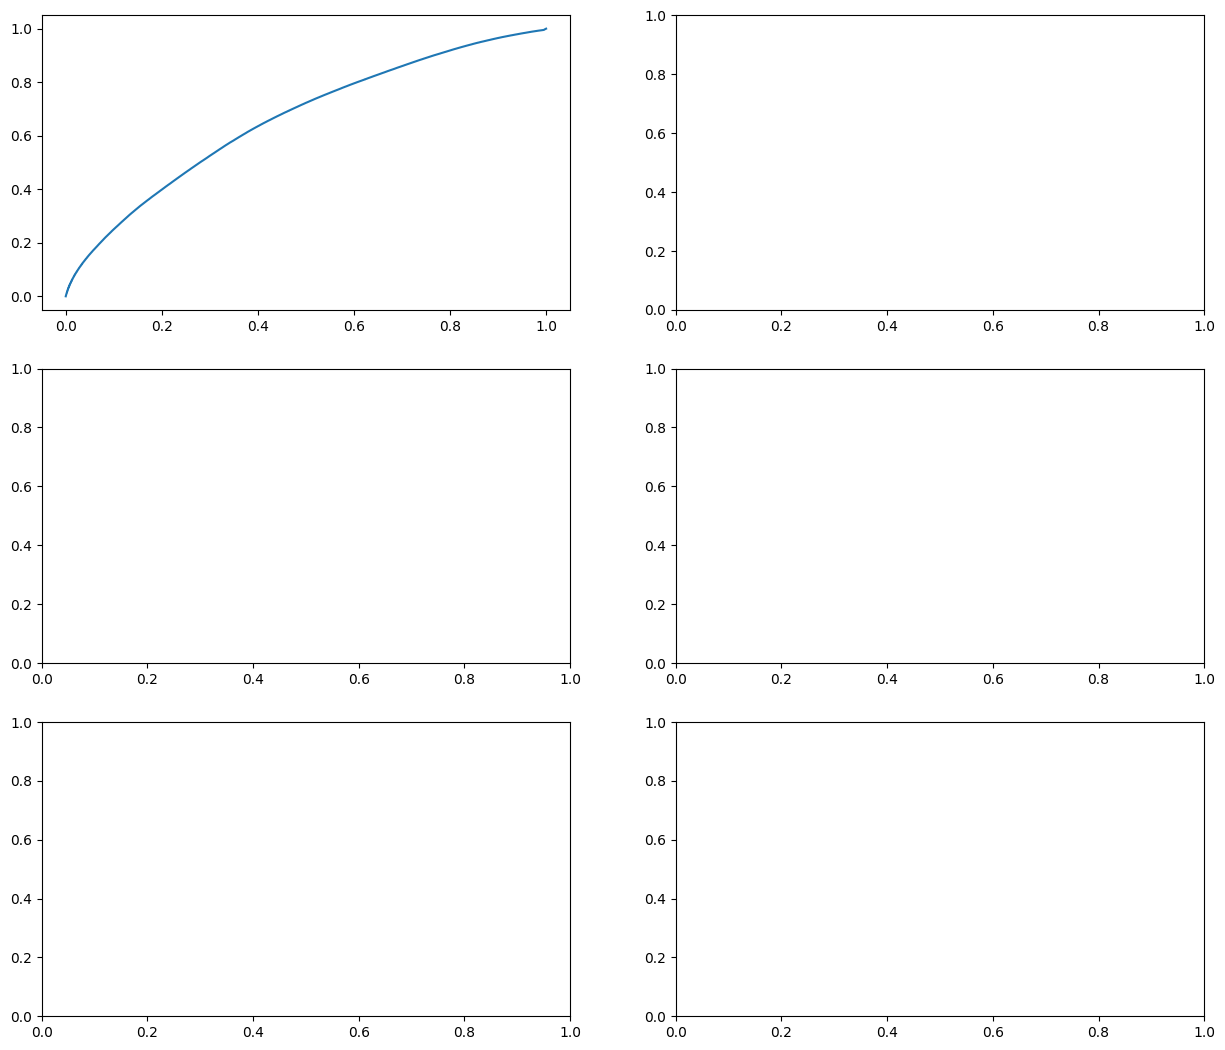

In [7]:
model.eval()

y_pred = []

size = 10000

for eeg_batch, _ in tqdm(train_dataloader_):
    for idx in range((eeg_batch.shape[-1] + size - 1) // size):
        with torch.no_grad():
            eeg_batch_ = eeg_batch[:, :, idx*size: (idx+1)*size].to(device)

            logits = model(eeg_batch_)
            probs = torch.sigmoid(logits).cpu().numpy()[0]

            y_pred.append(probs)

y_pred = np.concatenate(y_pred, axis=1).T
y_true = np.concatenate(ys_train, axis=0)

plot_roc(y_true.T, y_pred.T)

print('roc auc: ', metrics.roc_auc_score(y_true, y_pred))

# Score on val part

In [ ]:
model.eval()

y_pred = []

size = 10000

for eeg_batch, _ in tqdm(valid_dataloader):
    for idx in range((eeg_batch.shape[-1] + size - 1) // size):
        with torch.no_grad():
            eeg_batch_ = eeg_batch[:, :, idx*size: (idx+1)*size].to(device)

            logits = model(eeg_batch_)
            probs = torch.sigmoid(logits).cpu().numpy()[0]

            y_pred.append(probs)

y_pred = np.concatenate(y_pred, axis=1).T
y_true = np.concatenate(ys_valid, axis=0)

plot_roc(y_true.T, y_pred.T)

print('roc auc: ', metrics.roc_auc_score(y_true, y_pred))

# Create submission

In [ ]:
import pandas as pd
from tqdm import tqdm

xs_test = []
lengths = {}

testdir = Path('test')

FNAME = 'subj{}_series{}_{}.csv'

for subj in range(1, 13):
    for series in [9, 10]:
        datapath = testdir / FNAME.format(subj, series, 'data')

        x = pd.read_csv(datapath)
        x = x.iloc[:,1:].values

        xs_test.append(x.astype(np.float32))
        lengths['{}_{}'.format(subj, series)] = xs_test[-1].shape[0]

In [ ]:
class EEGDatasetTest(Dataset):
    def __init__(self, x):
        self.x = x

    def __getitem__(self, idx):
        eeg = self.x[idx]

        return eeg.T

    def __len__(self):
        return len(self.x)

dataset = EEGDatasetTest(xs_test)
test_dataloader = DataLoader(dataset, batch_size=1, num_workers=3, shuffle=False)

In [ ]:
model.eval()

y_pred = []

size = 10000

for eeg_batch in tqdm(test_dataloader):
    for idx in range((eeg_batch.shape[-1] + size - 1) // size):
        with torch.no_grad():
            eeg_batch_ = eeg_batch[:, :, idx*size: (idx+1)*size].to(device)

            logits = model(eeg_batch_)
            probs = torch.sigmoid(logits).cpu().numpy()[0]

            y_pred.append(probs)

y_pred = np.concatenate(y_pred, axis=1).T

In [ ]:
submission = pd.DataFrame(y_pred, index=['subj{}_series{}_{}'.format(sbj, i, j) for sbj in range(1, 13) for i in [9, 10] for j in range(lengths['{}_{}'.format(sbj, i)])], columns=labels)
submission.to_csv('Submission.csv', index_label='id', float_format='%.3f')

submission.tail()

In [ ]:
!head Submission.csv

In [ ]:
!head sample_submission.csv